In [1]:
import os
import cv2
import yaml
import torch
import numpy as np
import pandas as pd
from  torch import nn
import mediapipe as mp
from torch import optim
from datetime import datetime
from torchmetrics import Accuracy
from torch.utils.data import Dataset

In [2]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        list_label = label_dict_from_config_file("hand_gesture.yaml")

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(63, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(p=0.4),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(p=0.6),
            nn.Linear(128, len(list_label))
        )
    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits 

    def predict(self,x,threshold=0.8):
        logits = self(x)
        softmax_prob = nn.Softmax(dim=1)(logits)
        chosen_ind = torch.argmax(softmax_prob,dim=1)
        return torch.where(softmax_prob[0,chosen_ind]>threshold,chosen_ind,-1)

    def predict_with_known_class(self,x):
        logits = self(x)
        softmax_prob = nn.Softmax(dim=1)(logits)
        return torch.argmax(softmax_prob,dim=1)

    def score(self,logits):
        return -torch.amax(logits,dim=1)

In [3]:
def label_dict_from_config_file(relative_path):
    with open(relative_path,"r") as f:
       label_tag = yaml.full_load(f)["gestures"]
    return label_tag

In [4]:
class HandLandmarksDetector():
    def __init__(self) -> None:
        self.mp_drawing = mp.solutions.drawing_utils
        self.mp_drawing_styles = mp.solutions.drawing_styles
        self.mp_hands = mp.solutions.hands
        self.detector = self.mp_hands.Hands(False,max_num_hands=1,min_detection_confidence=0.5)

    def detectHand(self,frame):
        hands = []
        frame = cv2.flip(frame, 1)
        annotated_image = frame.copy()
        results = self.detector.process(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        if results.multi_hand_landmarks is not None:
            for hand_landmarks in results.multi_hand_landmarks:
                hand = []
                self.mp_drawing.draw_landmarks(
                    annotated_image,
                    hand_landmarks,
                    self.mp_hands.HAND_CONNECTIONS,
                    self.mp_drawing_styles.get_default_hand_landmarks_style(),
                    self.mp_drawing_styles.get_default_hand_connections_style())
                for landmark in hand_landmarks.landmark:
                    x,y,z = landmark.x,landmark.y,landmark.z
                    hand.extend([x,y,z])
            hands.append(hand)
        return hands,annotated_image

In [5]:
class CustomImageDataset(Dataset):
    def __init__(self, data_file):
        self.data = pd.read_csv(data_file)
        self.labels = torch.from_numpy(self.data.iloc[:,0].to_numpy())

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        one_hot_label = self.labels[idx]
        torch_data = torch.from_numpy(self.data.iloc[idx,1:].to_numpy(dtype=np.float32))
        return torch_data, one_hot_label

In [6]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.watched_metrics = np.inf

    def early_stop(self, current_value):
        if current_value < self.watched_metrics:
            self.watched_metrics = current_value
            self.counter = 0
        elif current_value > (self.watched_metrics + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [7]:
def train(trainloader, val_loader, model, loss_function, early_stopper, optimizer):
    losses = {}
    losses['training'] = []
    losses['valid'] = []
    
    accuracy = {}
    accuracy['trainning'] = []
    accuracy['valid'] = []
    # add auroc score
    best_vloss = 1_000_000
    timestamp = datetime.now().strftime('%d-%m_%H-%M')
    for epoch in range(300):
        loss_epoch_train = 0
        loss_epoch_valid = 0
        #training step
        model.train(True)
        running_loss = 0.0
        acc_train = Accuracy(num_classes=len(LIST_LABEL), task='MULTICLASS')
        for batch_number,data in enumerate(trainloader):
            inputs,labels = data

            optimizer.zero_grad()
            preds = model(inputs)
            
            loss = loss_function(preds, labels)
            loss_epoch_train += loss.item()
            loss.backward()
            optimizer.step()

            acc_train.update(model.predict_with_known_class(inputs), labels)
            running_loss += loss.item()

        avg_loss = running_loss / len(trainloader)
        # validating step
        model.train(False)
        running_vloss = 0.0
        acc_val = Accuracy(num_classes=len(LIST_LABEL), task='MULTICLASS')
        for i, vdata in enumerate(val_loader):
            vinputs, vlabels = vdata
            preds = model(vinputs)
            vloss = loss_function(preds, vlabels)
            loss_epoch_valid += vloss.item()
            running_vloss += vloss.item()
            acc_val.update(model.predict_with_known_class(vinputs), vlabels)

        loss_epoch_train /= len(trainloader)
        losses['training'].append(loss_epoch_train)
        loss_epoch_valid /= len(val_loader)
        losses['valid'].append(loss_epoch_valid)
        
        accuracy['trainning'].append(acc_train.compute().item())
        accuracy['valid'].append(acc_val.compute().item())
        
        # Log the running loss averaged per batch
        # for both training and validation
        print(f"Epoch {epoch}: ")
        print(f"Accuracy train:{acc_train.compute().item()}, val:{acc_val.compute().item()}")
        avg_vloss = running_vloss / len(val_loader)
        print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))
        print('Training vs. Validation Loss',
                        { 'Training' : avg_loss, 'Validation' : avg_vloss },
                        epoch + 1)
        print('Training vs. Validation accuracy',
                        { 'Training' : acc_train.compute().item()
                        , 'Validation' : acc_val.compute().item() },
                        epoch + 1)

        # Track best performance, and save the model's state
        if avg_vloss < best_vloss:
            best_vloss = avg_vloss
            best_model_path = f'./{save_path}/model_{timestamp}_{model.__class__.__name__}_best'
            torch.save(model.state_dict(), best_model_path)

        if early_stopper.early_stop(avg_vloss):
            print(f"Stopping at epoch {epoch}, minimum: {early_stopper.watched_metrics}")
            break

    model_path = f'./{save_path}/model_{timestamp}_{model.__class__.__name__}_last'
    torch.save(model.state_dict(), model_path)

    print(acc_val.compute())
    return model, best_model_path, losses, accuracy

In [8]:
DATA_FOLDER_PATH="./data/"
LIST_LABEL = label_dict_from_config_file("hand_gesture.yaml")
train_path = os.path.join(DATA_FOLDER_PATH,"landmark_train.csv")
val_path = os.path.join(DATA_FOLDER_PATH,"landmark_val.csv")
save_path = './models'
os.makedirs(save_path,exist_ok=True)

trainset = CustomImageDataset(train_path)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=40, shuffle=True)

valset = CustomImageDataset(os.path.join(val_path))
val_loader = torch.utils.data.DataLoader(valset,batch_size=50, shuffle=False)

model = NeuralNetwork()
loss_function = nn.CrossEntropyLoss()
early_stopper = EarlyStopper(patience=30, min_delta=0.01)

optimizer = optim.Adam(model.parameters(), lr=0.0001)

model, best_model_path, losses,accuracy = train(trainloader, val_loader, model, loss_function, early_stopper, optimizer)

Epoch 0: 
Accuracy train:0.3403141498565674, val:0.5997757911682129
LOSS train 1.5572016146275904 valid 1.5084938164110537
Training vs. Validation Loss {'Training': 1.5572016146275904, 'Validation': 1.5084938164110537} 1
Training vs. Validation accuracy {'Training': 0.3403141498565674, 'Validation': 0.5997757911682129} 1
Epoch 1: 
Accuracy train:0.5291230082511902, val:0.4260089695453644
LOSS train 1.332880609995359 valid 1.1798818751617715
Training vs. Validation Loss {'Training': 1.332880609995359, 'Validation': 1.1798818751617715} 2
Training vs. Validation accuracy {'Training': 0.5291230082511902, 'Validation': 0.4260089695453644} 2
Epoch 2: 
Accuracy train:0.6708115339279175, val:0.8557548522949219
LOSS train 0.9300734300117988 valid 0.8008374550759241
Training vs. Validation Loss {'Training': 0.9300734300117988, 'Validation': 0.8008374550759241} 3
Training vs. Validation accuracy {'Training': 0.6708115339279175, 'Validation': 0.8557548522949219} 3
Epoch 3: 
Accuracy train:0.842931

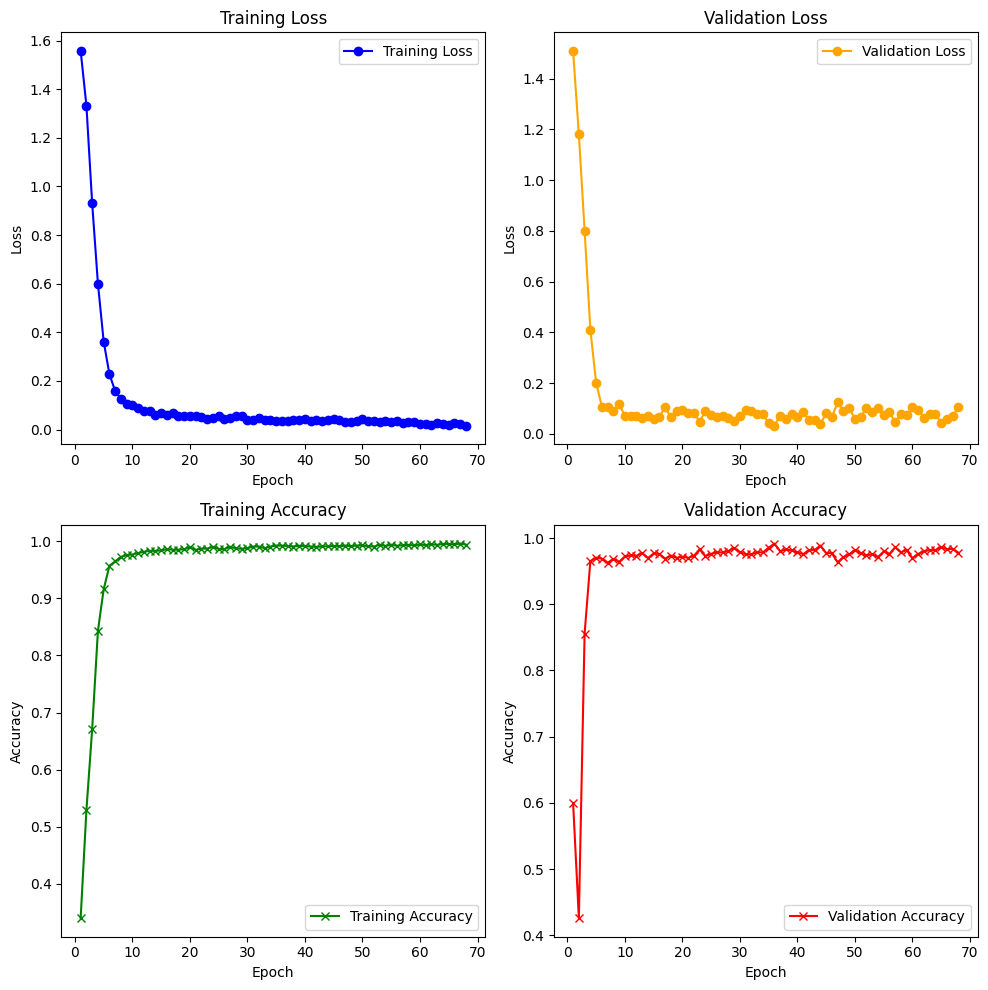

In [21]:
import matplotlib.pyplot as plt

# Create a 2x2 grid for the subplots (axes[0][0], axes[0][1], axes[1][0], axes[1][1])
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

epochs = [i for i in range(1, 69)]

# Plot Training Loss in axes[0][0]
axes[0][0].plot(epochs, losses['training'], label='Training Loss', color='blue', marker='o')
axes[0][0].set_title('Training Loss')
axes[0][0].set_xlabel('Epoch')
axes[0][0].set_ylabel('Loss')
axes[0][0].legend()

# Plot Training Accuracy in axes[0][1]
axes[1][0].plot(epochs, accuracy['trainning'], label='Training Accuracy', color='green', marker='x')
axes[1][0].set_title('Training Accuracy')
axes[1][0].set_xlabel('Epoch')
axes[1][0].set_ylabel('Accuracy')
axes[1][0].legend()

# Plot Validation Loss in axes[1][0]
axes[0][1].plot(epochs, losses['valid'], label='Validation Loss', color='orange', marker='o')
axes[0][1].set_title('Validation Loss')
axes[0][1].set_xlabel('Epoch')
axes[0][1].set_ylabel('Loss')
axes[0][1].legend()

# Plot Validation Accuracy in axes[1][1]
axes[1][1].plot(epochs, accuracy['valid'], label='Validation Accuracy', color='red', marker='x')
axes[1][1].set_title('Validation Accuracy')
axes[1][1].set_xlabel('Epoch')
axes[1][1].set_ylabel('Accuracy')
axes[1][1].legend()

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

In [18]:
list_label = label_dict_from_config_file("hand_gesture.yaml")
DATA_FOLDER_PATH="./data/"
testset = CustomImageDataset(os.path.join(DATA_FOLDER_PATH,"landmark_test.csv"))

test_loader = torch.utils.data.DataLoader(trainset, batch_size=20, shuffle=False)

network = NeuralNetwork()
network.load_state_dict(torch.load(best_model_path, weights_only=False))

network.eval()
acc_test = Accuracy(num_classes=len(list_label), task='MULTICLASS')
for i, test_data in enumerate(test_loader):
    test_input, test_label = test_data

    preds = network(test_input)
    
    acc_test.update(preds, test_label)

print(network.__class__.__name__)
print(f"Accuracy of model:{acc_test.compute().item()}")
print("========================================================================")

NeuralNetwork
Accuracy of model:0.9937826991081238
